In [1]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy as np

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

import math
from scipy.ndimage import gaussian_filter

%matplotlib inline

20.0.0-4-gde602ef96+1


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]
[0.00000000e+000 0.00000000e+000 6.02562418e-277 1.30739184e-228
 1.21148028e-184 7.11944804e-146 3.02382453e-111 1.08944657e-081
 1.52397759e-056 3.94966546e-036 2.74339844e-020 3.89408303e-009
 1.25588740e-002 9.43638875e-001 9.52558239e-001 1.61231863e-003
 6.20880101e-011 5.28099940e-023 1.04766134e-039 4.59087746e-061
 5.43700854e-087 1.55385810e-117 7.36116708e-153 6.05725044e-193
 1.00906785e-227 1.60551096e-237 1.05105196e-286 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

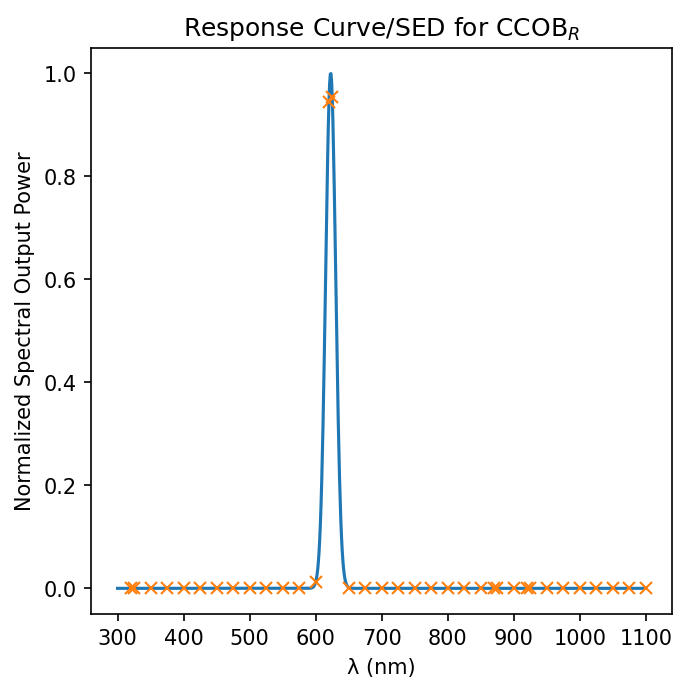

In [3]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)



# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)
# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma


# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
         # gaussians #
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
# plots the gaussians
pylab.plot(x, y)

# corrects for the difference in resolution for each wavelength in wls, it will interpolate numbers at wls*10 for this case.
# interpolation is a method of curve fitting using linear polynomials to construct NEW data points within the range of a discrete set of KNOWN data points
weights = numpy.interp(wls, x, y)    # THIS FUNCTION IS CALLED LATER ON, RESPONSIBLE FOR CREATING COMBINED FOR UV BAND #
print(weights)
# plots 'x's
pylab.plot(wls, weights,"x")


# labeling plot
pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

In [4]:
import numpy as np
import matplotlib.pyplot as plt

superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias


num_ch  = 16    # number of channels/amplifiers/segments in CCD
img_list_top_row = []
img_list_bottom_row = []
# loops over each amplifier in the CCD
for ch in range(num_ch):
    arr = []        # defines an empty array for storing new combined flat for each amplifier
    for i, aqeflatpath in enumerate(qeflatpath):
        aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)

        img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array
        img = img/img.mean()     # this will normalize your image

        arr.append(img*weights[i])
        arr.append(img*weights[i])
        
    img = numpy.sum(arr,axis=0)/numpy.sum(weights) # NEED THIS LINE TO MAKE COMBINED IN UV BAND (weights function called)
    mean = img.mean()
    std = mad_std(img)
    N = 3
    
    # puts images into a list to use below
    
    if ch < num_ch / 2:
        img_list_top_row.append(img)
    else:
        img_list_bottom_row.append(img)

# because the mosaic is jumbled otherwise/symmetry/alignment of sensors is off
img_list_top_row.reverse()

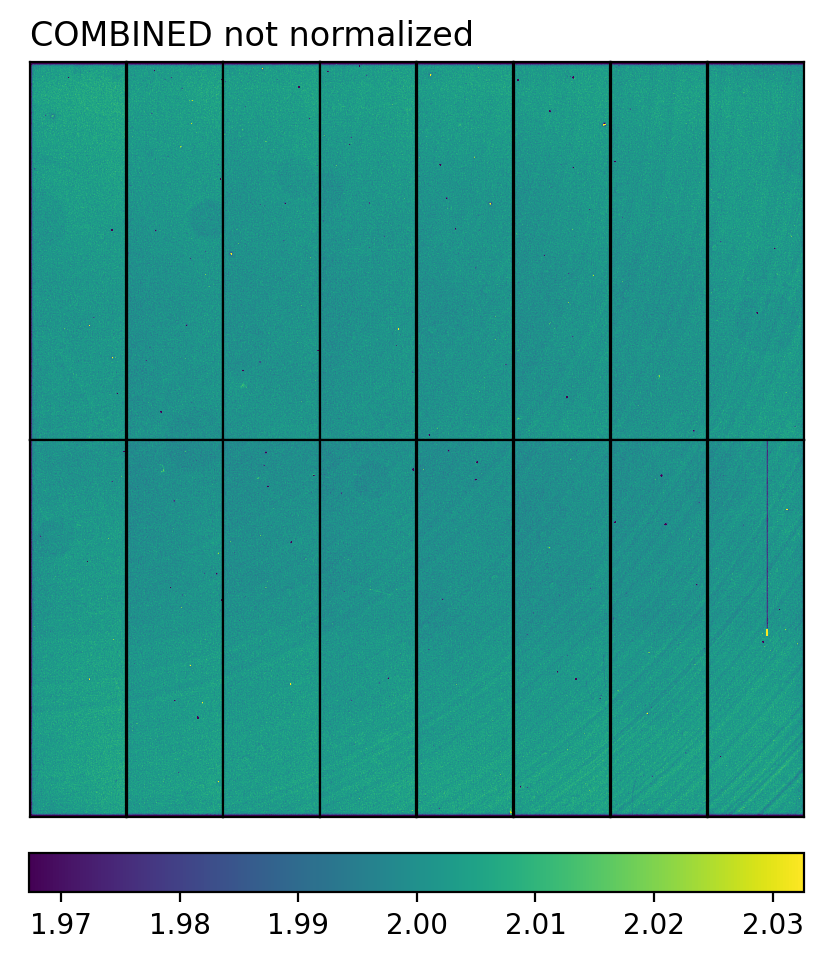

In [5]:
fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

wholepixels = numpy.array(img_list_top_row + img_list_bottom_row).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    
    if i < 9:
        image_com = np.flipud(img_list_top_row[i - 1])

    else:
        image_com = img_list_bottom_row[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    ax.append(ax1)
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    #mean = image_com.mean()
    #std = mad_std(image_com)
    
    N = 1
    
    if i == 1:
        plt.title("COMBINED not normalized", loc='left')
    im = plt.imshow(image_com, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar
fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))

# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [6]:
red_top = []
red_bot = []
normedimg_top = []
normedimg_bot = []


# reading in files in CCOB testing at uv and red LEDs for each of 16 channels 
for ch in range(num_ch):
    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
    ccob_red = get_ccd_from_id(None, fname, [])
    print ( mad_std(get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]))
    

    # normalize flat 
    red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]   # this is the CCOB(red) flat image
    
    # adding image data arrays to a list for the top row of amplifiers!!! these lists will need to be reversed due to asymmetry of ITL (?) sensors
    if ch < columns:
        # changed this normalization to red!! this is basically the combined flat normalized with CCOB(r), so the "new combined" flat image
        normedimg = img_list_top_row[ch]/img_list_top_row[ch].mean()*red.mean()
        normedimg_top.append(normedimg)
        red_top.append(red)
    # adding image data arrays to a list for the bottom row
    else:
        normedimg = img_list_bottom_row[ch - columns]/img_list_bottom_row[ch - columns].mean()*red.mean()
        normedimg_bot.append(normedimg)
        red_bot.append(red)
        
        
#normedimg_top list does not need to be reversed since it is created from combined image list which is already reversed for top row
## reversing the top row image lists to orient sensor mosaic correctly 
red_top.reverse()

464.05449439225345
447.7458699886918
444.7806655516806
441.8154611146694
441.8154611146694
438.8502566776582
437.3676544591526
446.2632677701862
443.298063333175
437.3676544591526
438.8502566776582
441.8154611146694
438.8502566776582
440.3328588961638
443.298063333175
461.08928995524224


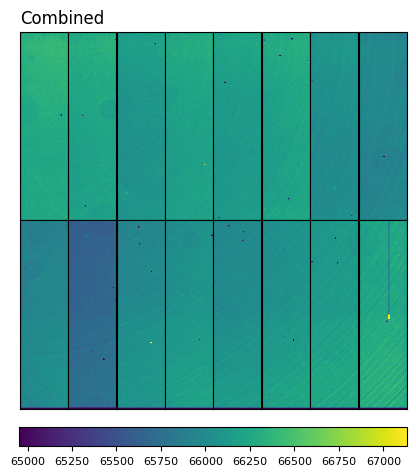

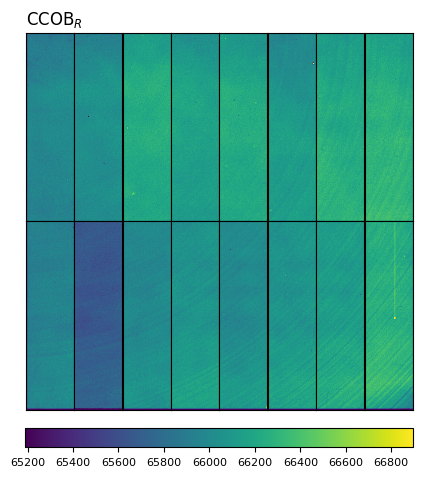

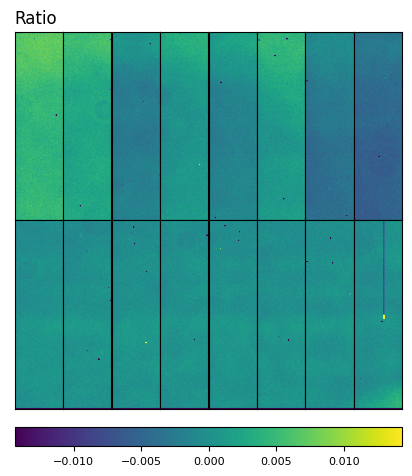

In [14]:
# GOAL: show full flats side-by-side, default color map: viridis for RED BAND

# normedimg flat (combined)

fig=plt.figure(figsize=(5, 5), dpi=100)   # dpi : dot per inch
columns = 8
rows = 2

wholepixels = numpy.array(normedimg_top + normedimg_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(normedimg_top[i - 1])

    else:
        image = normedimg_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    
    ax.append(ax1)
   
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    #mean = image.mean()
    #std = mad_std(image)
    N = 1
    
    if i == 1:
        plt.title("Combined", loc='left')
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# CCOBr flat
fig=plt.figure(figsize=(5, 5), dpi=100)   # dpi : dot per inch
columns = 8
rows = 2

wholepixels = numpy.array(red_top + red_bot).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []


for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(red_top[i - 1])

    else:
        image = red_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    
    ax.append(ax1)
    
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    
    #mean = image.mean()       # no weights function needed becasue this data is acquired from using uv band already
    #std = mad_std(image)
    N = 1
    
    if i == 1:
        plt.title(r"CCOB$_{R}$", loc='left')
        
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)
# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# ratio flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2

array = (numpy.array(normedimg_top) - numpy.array(red_top)) / numpy.array(red_top) + (numpy.array(normedimg_bot) - numpy.array(red_bot)) / numpy.array(red_bot)

wholepixels = numpy.array(array).flatten()
mean = numpy.mean(wholepixels,dtype=numpy.float64)
std = numpy.std(wholepixels,dtype=numpy.float64)
ax = []

for i in range(1, (columns*rows) + 1):                              
    if i < 9:
        image = np.flipud(((normedimg_top[i - 1]) - (red_top[i - 1])) / (red_top[i - 1]))
    else:
        image = ((normedimg_bot[i - 1 - columns]) - (red_bot[i - 1 - columns])) / (red_bot[i - 1 - columns])

    ax1 = fig.add_subplot(rows, columns, i)
    
    ax.append(ax1)
    
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    if i == 1:
        plt.title("Ratio", loc='left')
    
    #mean = image.mean()
    #std = mad_std(image)
    N = 1
    
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
cbar.ax.tick_params(labelsize=8)   
# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

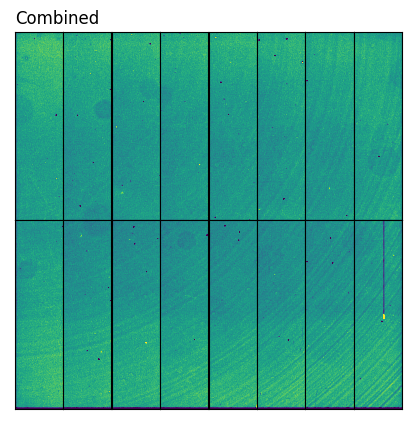

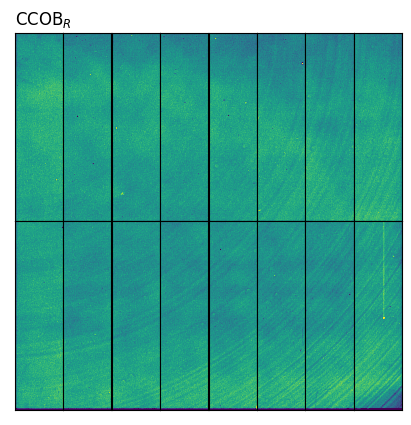

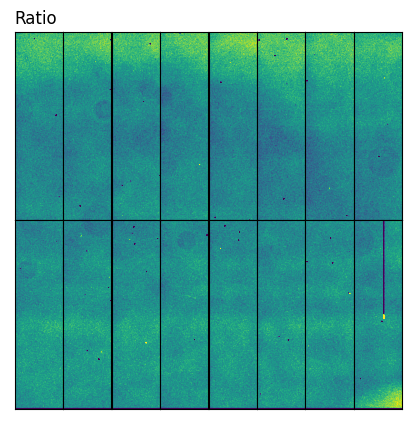

In [9]:
## No colorbar


# normedimg flat (combined)
fig=plt.figure(figsize=(5, 5), dpi=100)   # dpi : dot per inch
columns = 8
rows = 2



for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(normedimg_top[i - 1])

    else:
        image = normedimg_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
   
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    mean = image.mean()
    std = mad_std(image)
    N = 1
    
    if i == 1:
        plt.title("Combined", loc='left')
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")


# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# CCOBr flat
fig=plt.figure(figsize=(5, 5), dpi=100)   # dpi : dot per inch
columns = 8
rows = 2


for i in range(1, (columns*rows) + 1):
    if i < 9:
        image = np.flipud(red_top[i - 1])

    else:
        image = red_bot[i - 1 - columns]
        
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    
    mean = image.mean()       # no weights function needed becasue this data is acquired from using uv band already
    std = mad_std(image)
    N = 1
    
    if i == 1:
        plt.title(r"CCOB$_{R}$", loc='left')
        
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")


# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()



# ratio flat
fig=plt.figure(figsize=(5, 5), dpi=100)   
columns = 8
rows = 2


for i in range(1, (columns*rows) + 1):                              
    if i < 9:
        image = np.flipud(((normedimg_top[i - 1]) - (red_top[i - 1])) / (red_top[i - 1]))
    else:
        image = ((normedimg_bot[i - 1 - columns]) - (red_bot[i - 1 - columns])) / (red_bot[i - 1 - columns])

    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    if i == 1:
        plt.title("Ratio", loc='left')
    
    mean = image.mean()
    std = mad_std(image)
    N = 1
    
    im = plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

    
# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()